# Baseballs in Flight

In this problem, I simulated the flight of batted baseballs in a 3D Cartesian coordinate system.
- The **y-axis** points forward along the ground.
- The **z-axis** points vertically up.
- The **x-axis** points to the right of the forward trajectory.
- The ball's initial velocity is in the y-z plane.

The launch angle, $\theta$, is the angle of the velocity vector with respect to the horizontal:

$$
\begin{align}
\vec{v} &= v_x \hat{x} + v_y \hat{y} + v_z \hat{z} \\
v_x &= 0 \\
v_y &= v \cos \theta \\
v_z &= v \sin \theta
\end{align}
$$

where $v$ is the magnitude of the velocity, and $\hat{v} = \vec{v}/v$.

The trajectory is influenced by three forces:

1. **Gravity**:

$$
F_{G_z} = -mg
$$

2. **Air Resistance (Drag)**:

    $$
    \vec{F_D} = -\frac{1}{2} C_D A \rho v^2 \hat{v}, \quad
    C_D = C_{D,0} + C_{D,1} \frac{\omega}{16.67\ \mathrm{rot/s}}
    $$

    where $C_D$ is the drag coefficient, $A$ is the cross-sectional area, $\rho$ is the air density, and $\omega$ is the spin rate.


3. **Magnus Force (Spin)**:

    $$
    \vec{F_M} = \frac{1}{2} A \rho C_L v^2 (\hat{\omega} \times \hat{v})
    $$

    with the lift coefficient:
    $$
    C_L = \frac{C_{L,2} S}{C_{L,0} + C_{L,1} S}, \quad
    S = \frac{r \omega}{v}
    $$
- Here, $S$ is the scalar spin factor.
- For this simulation, $\vec{\omega}$ is along the x-axis only.
- Back-spin corresponds to $\omega_x > 0$, top-spin to $\omega_x < 0$.

All relevant constants (mass, radius, coefficients, air density, gravity) are provided below.


## Imports and Constants

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import time
import scipy.linalg
from scipy.signal import find_peaks
from scipy import signal
from scipy.integrate import solve_ivp



In [2]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 14

In [3]:
# baseball constants
m = 0.145 # mass in kg
c = 23.2  # circumference in cm
r = c / 2 / np.pi / 100 # radius in m
A = np.pi * (r)**2 # cross-sectional area in m^2

# drag coefficients
CD0 = 0.297
CD1 = 0.0292

# lift coefficients
CL0 = 0.583
CL1 = 2.333
CL2 = 1.120

# Earth-related constants
rhoE = 1.18 # air density at sea level kg/m^3
g = 9.80665 # gravitational acceleration m/s^2

## Task 1: Motion of a Batted Baseball

In this task, I compute the flight of a batted baseball under four scenarios:

1. Gravity only (no drag or Magnus forces)  
2. Gravity + drag forces with no spin ($\omega = 0$)  
3. Gravity + drag with spin $\vec{\omega} = (50\ \mathrm{rot/s}) \hat{x}$, without Magnus force  
4. Gravity + drag + Magnus force with $\vec{\omega} = (50\ \mathrm{rot/s}) \hat{x}$  

The conditions of flight are as follows:
- The initial position of the ball is 1 m off the ground (the height of a hittable pitch) at the origin of the x-y plane, i.e. (0, 0, 1) m.
- The ball lands when its height reaches 0.


### Function: `p3_task1`

The function accepts the following parameters:
- `vi`: initial speed (m/s)  
- `theta`: launch angle (degrees)  

The function outputs:
- Four numbers representing the ground displacement of the ball in each scenario (meters)  
- The function also plots ground displacement vs. height for all cases.

I use the constants defined above (`m, r, A, CD0, CD1, CL0, CL1, CL2, rhoE, g`) in all calculations.

### Approach

1. Set initial position and velocity based on `vi` and `theta`.
2. Compute accelerations from gravity, drag, and Magnus force for each scenario.
3. Integrate the equations of motion until the ball lands (`z = 0`).
4. Record ground displacement and height for each scenario.
5. Plot height vs. ground displacement and return the final distances.

In [4]:
def p3_task1(vi, theta):
    
    def motion(t, f):
        omega = 50
        CD = CD0 + CD1*(omega/16.67)
        S = r*omega/np.sqrt(f[3]**2 + f[4]**2 +f[5]**2)
        CL = (CL2*S)/(CL0 + CL1*S)
        
        aD_y = 0 #drag acceleration in y direction
        aD_z = 0 # '...' in z direction
        aM_y = 0 #magnus acceleration in y direction
        aM_z = 0 # '...' in z direction

        if i == 1:
            aD_y = -(1/(2*m))*CD0*A*rhoE*np.sqrt(f[3]**2 + f[4]**2 + f[5]**2)*f[4] 
            aD_z = -(1/(2*m))*CD0*A*rhoE*np.sqrt(f[3]**2 + f[4]**2 + f[5]**2)*f[5] 
        elif i == 2:
            aD_y = -(1/(2*m))*CD*A*rhoE*np.sqrt(f[3]**2 + f[4]**2 + f[5]**2)*f[4]
            aD_z = -(1/(2*m))*CD*A*rhoE*np.sqrt(f[3]**2 + f[4]**2 + f[5]**2)*f[5]
        elif i == 3:
            aD_y = -(1/(2*m))*CD*A*rhoE*np.sqrt(f[3]**2 + f[4]**2 + f[5]**2)*f[4]
            aD_z = -(1/(2*m))*CD*A*rhoE*np.sqrt(f[3]**2 + f[4]**2 + f[5]**2)*f[5]
            aM_y = -(1/(2*m))*CL*A*rhoE*np.sqrt(f[3]**2 + f[4]**2 + f[5]**2)*f[5] 
            aM_z = (1/(2*m))*CL*A*rhoE*np.sqrt(f[3]**2 + f[4]**2 + f[5]**2)*f[4] 
        
        vals = np.zeros_like(f)
        vals[0] = f[3]
        vals[1] = f[4]
        vals[2] = f[5]
        vals[3] = 0
        vals[4] = aD_y + aM_y
        vals[5] = aD_z + aM_z - g 
        return vals
    
    def lands(t, f):
        return f[2]
    lands.terminal = True
    lands.direction = -1
    
    theta = theta * np.pi/180 #degrees to radians
    fi = np.array([0, 0, 1, 0, vi*np.cos(theta), vi*np.sin(theta)]) #initial f
    
    sol = []    
    final_displacement = []
    ground_displacement = []
    height = []

    for i in range(4):
        sol.append(solve_ivp(motion, (0, 25), fi, events=(lands), dense_output=True))
        tf = sol[i].t_events[0][0] #final time
        t = np.linspace(0, tf, 100)
        f = sol[i].sol(t)
        ground_displacement.append(f[1])
        height.append(f[2])
        final_displacement.append(ground_displacement[i][-1])
    
    #plot
    plt.plot(ground_displacement[0], height[0], label = "gravity", color = "green")
    plt.plot(ground_displacement[1], height[1], label = "gravity and drag (ω = 0)", color = "blue")
    plt.plot(ground_displacement[2], height[2], label = "gravity and drag (ω = 50)", color = "black")
    plt.plot(ground_displacement[3], height[3], label = "gravity, drag and magnus (ω = 50)", color = "teal")
    plt.xlabel("Ground Displacement (m)")
    plt.ylabel("Height (m)")
    plt.legend(loc='upper right', fontsize = 10)
    plt.title("Ground displacement vs. Height of Batted Baseball with Varying Forces")
    
    return final_displacement[0], final_displacement[1], final_displacement[2], final_displacement[3]


### Example Implementation

Simulation Distances:
(154.73025496793937, 101.63461672423725, 93.08245881863022, 98.82553678168419) m.

True distances:
[154.73025496793943, 101.63461672423742, 93.08091816428875, 98.8237443311187] m.

Errors:
[5.68434189e-14 1.70530257e-13 1.54065434e-03 1.79245057e-03] m.


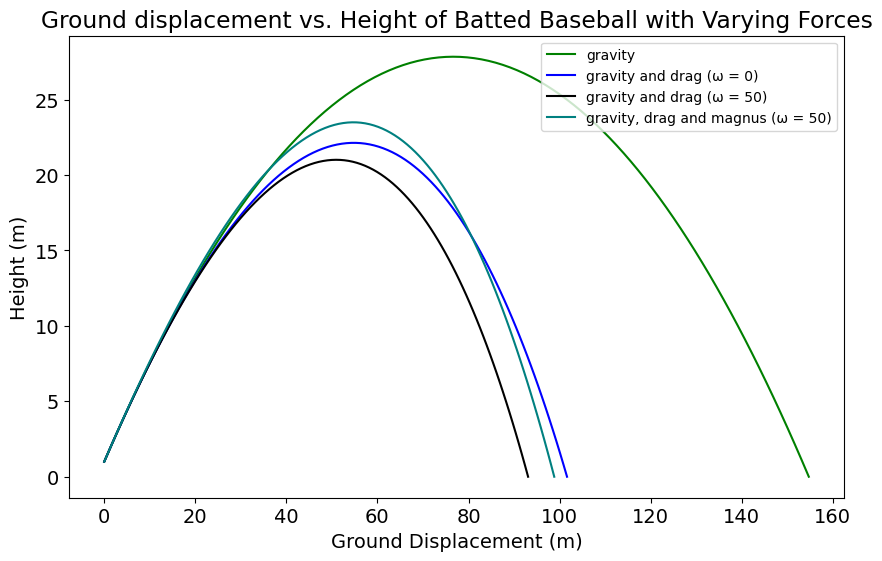

In [5]:
vi = 40 # m/s
theta = 35 # degrees
dis_true = [154.73025496793943, 101.63461672423742, 93.08091816428875, 98.8237443311187]
dis = p3_task1(vi, theta)
print (f"Simulation Distances:\n{dis} m.")
print (f"\nTrue distances:\n{dis_true} m.")
err = np.abs(np.array(dis) - np.array(dis_true))
print (f"\nErrors:\n{err} m.")
assert (err < 0.1).all()

## Task 2: Fraction of Baseballs Exceeding a Threshold Distance

In this task, I simulate a distribution of batted baseballs to determine the fraction that travel at least a specified distance. I assume that the initial conditions of the ball are not fixed, but rather drawn from normal distributions:

- Initial speed $v_i$: mean and standard deviation in m/s  
- Launch angle $\theta$: mean and standard deviation in degrees  
- Spin rate $\omega$: mean and standard deviation in rotations per second  

The goal is to compute the fraction of balls whose ground displacement exceeds a threshold distance.

### Function: `p3_task2`

The function accepts the following parameters:

- `vi_mean`, `vi_std`: mean and standard deviation of initial speed (m/s)  
- `theta_mean`, `theta_std`: mean and standard deviation of launch angle (degrees)  
- `spin_mean`, `spin_std`: mean and standard deviation of spin rate (rot/s) 
- `distance`: threshold distance (m)  

The function outputs:
- Fraction of simulated balls exceeding the given distance.

I use the constants defined above (`m, r, A, CD0, CD1, CL0, CL1, CL2, rhoE, g`) in all calculations.

### Approach

1. Generate `N` random samples for speed, launch angle, and spin from the specified normal distributions.  
2. For each sample, compute the flight using the equations of motion including gravity, drag, and Magnus force.  
3. Record the ground displacement of each trajectory.  
4. Count how many balls exceed the threshold distance.  
5. Return the fraction exceeding the distance.

**Note:** Choice of $N$ accounts for the relative uncertainty of sampling $N^{-1/2}$ for an uncertainty of $0.0058$.


In [6]:
def p3_task2(vi_mean, vi_std, theta_mean, theta_std, spin_mean, spin_std, distance):

    def motion2(t, f):
        CD = CD0 + CD1*(omega/16.67)
        S = r*omega/np.sqrt(f[3]**2 + f[4]**2 +f[5]**2)
        CL = (CL2*S)/(CL0 + CL1*S)

        aD_y = -(1/(2*m))*CD*A*rhoE*np.sqrt(f[3]**2 + f[4]**2 + f[5]**2)*f[4]
        aD_z = -(1/(2*m))*CD*A*rhoE*np.sqrt(f[3]**2 + f[4]**2 + f[5]**2)*f[5]
        aM_y = -(1/(2*m))*CL*A*rhoE*np.sqrt(f[3]**2 + f[4]**2 + f[5]**2)*f[5] 
        aM_z = (1/(2*m))*CL*A*rhoE*np.sqrt(f[3]**2 + f[4]**2 + f[5]**2)*f[4] 
        
        vals = np.zeros_like(f)
        vals[0] = f[3]
        vals[1] = f[4]
        vals[2] = f[5]
        vals[3] = 0
        vals[4] = aD_y + aM_y
        vals[5] = aD_z + aM_z - g 
        return vals

    def lands(t, f):
        return f[2]
    lands.terminal = True
    lands.direction = -1
    
    N = 30000 #number of simulations
    
    vi_values = np.random.normal(vi_mean, vi_std, N)
    theta_values = np.random.normal(theta_mean, theta_std, N)
    spin_values = np.random.normal(spin_mean, spin_std, N)
    
    num_exceeding_distance = 0
    
    for i in range(N):
        theta = theta_values[i] * np.pi/180 #degrees to radians
        fi = np.array([0, 0, 1, 0, vi_values[i]*np.cos(theta), vi_values[i]*np.sin(theta)]) #initial f
        omega = spin_values[i]
        sol = solve_ivp(motion2, (0, 25), fi, events=(lands), dense_output=True)
        tf = sol.t_events[0][0] #final time
        t = np.linspace(0, tf, 1000)
        f = sol.sol(t)
        final_displacement = f[1][-1]
        if final_displacement > distance:
            num_exceeding_distance += 1
    
    fraction_exceeding_distance = num_exceeding_distance / N
    
    return fraction_exceeding_distance
    

### Example Implementation

In [7]:
t1 = time.time()
val = p3_task2(30, 5, 20, 10, 33.33, 33.33, 100)
t2 = time.time()
print (f"Fraction is {val}.")
print (f"Computed in {t2-t1} seconds.")

Fraction is 0.0047.
Computed in 78.84972047805786 seconds.


## Task 3: Minimum Initial Speed for a Looping Baseball

In this task, I investigate the conditions under which a baseball can make a “loop” in its trajectory while landing in the same spot as a control run. The control run uses the following initial conditions:

* Initial speed: 50 m/s
* Launch angle: 30 degrees
* Spin rate: 50 rot/s

A minimal loop is defined as a flight where the forward velocity (`v_y`) briefly reverses before continuing forward. The goal is to find the minimum initial speed required to produce this loop while keeping the spin constant, and to plot the resulting trajectory.

### Function: `p3_task3`

The function:

* Uses the control run as a reference for landing position.
* Iteratively tests increasing initial speeds with a range of launch angles to find the speed that produces a loop and lands within 0.1 m of the control displacement.
* Returns the minimum initial speed and plots height vs. ground displacement for its respective looping trajectory.

I use the constants defined above (`m, r, A, CD0, CD1, CL0, CL1, CL2, rhoE, g`) in all calculations.

### Approach

1. Define the control trajectory using the given initial speed, angle, and spin.
2. Set a range of launch angles and an initial guess for the speed.
3. For each combination, simulate the flight using the equations of motion with gravity, drag, and Magnus forces.
4. Check if the forward velocity briefly reverses (`v_y < 0`) to identify a loop.
5. Compare the final displacement to the control run and iterate on initial speed until the minimal looping condition is met.
6. Record and return the minimum initial speed and plot the corresponding trajectory.

**Note:** The loop is considered minimal if the forward velocity becomes negative only briefly, and the landing displacement matches the control run within 0.1 m.


In [8]:
def p3_task3():
    
    def motion3(t, f):
        CD = CD0 + CD1*(omega/16.67)
        S = r*omega/np.sqrt(f[3]**2 + f[4]**2 +f[5]**2)
        CL = (CL2*S)/(CL0 + CL1*S)

        aD_y = -(1/(2*m))*CD*A*rhoE*np.sqrt(f[3]**2 + f[4]**2 + f[5]**2)*f[4]
        aD_z = -(1/(2*m))*CD*A*rhoE*np.sqrt(f[3]**2 + f[4]**2 + f[5]**2)*f[5]
        aM_y = -(1/(2*m))*CL*A*rhoE*np.sqrt(f[3]**2 + f[4]**2 + f[5]**2)*f[5] 
        aM_z = (1/(2*m))*CL*A*rhoE*np.sqrt(f[3]**2 + f[4]**2 + f[5]**2)*f[4] 
        
        vals = np.zeros_like(f)
        vals[0] = f[3]
        vals[1] = f[4]
        vals[2] = f[5]
        vals[3] = 0
        vals[4] = aD_y + aM_y
        vals[5] = aD_z + aM_z - g 
        return vals

    def lands(t, f):
        return f[2]
    lands.terminal = True
    lands.direction = -1
    
   
    omega = 50
    
    #control run:
    theta_control = 30 * np.pi/180 #degrees to radians
    vi_control = 50
    fi_control = np.array([0, 0, 1, 0, vi_control*np.cos(theta_control), vi_control*np.sin(theta_control)]) #initial f
    sol = solve_ivp(motion3, (0, 25), fi_control, events=(lands), dense_output=True)
    tf = sol.t_events[0][0] #final time
    t = np.linspace(0, tf, 1000)
    f = sol.sol(t)
    final_displacement_control = f[1][-1]

    N = 1000
    theta_values = np.linspace(75, 80, N) #set values of theta to try

    minimum_initial_speed = 0
    final_displacement = 0
    loop = False
        
    vi = 750 #set initial speed to try


    while np.abs(final_displacement_control - final_displacement) >= 0.1 or loop == False:  
        
        for theta in theta_values:
            
            theta = theta * np.pi/180 #degrees to radians
            fi = np.array([0, 0, 1, 0, vi*np.cos(theta), vi*np.sin(theta)]) #initial f

            sol = solve_ivp(motion3, (0, 50), fi, events=(lands), dense_output=True)
            tf = sol.t_events[0][0] #final time
            t = np.linspace(0, tf, 1000)
            f = sol.sol(t)
            final_displacement = f[1][-1]
            
            if any(f[4] < 0): #if vy is negative
                loop = True
            else:
                loop = False
                        
            if np.abs(final_displacement_control - final_displacement) < 0.1 and loop == True:
                minimum_initial_speed = vi
                height = f[2]                
                displacement = f[1]
                break

        vi += 0.5      
        
    print("Minimum Inital Speed:", minimum_initial_speed, "m/s")
    
    plt.plot(displacement, height)
    plt.xlabel("displacement (m)")
    plt.ylabel("height (m)")
    plt.title("Trajectory of ball that lands in the same spot as the control run,\nbut with a loop, at minimum initial speed")
    plt.show()
            
    return minimum_initial_speed
    

Minimum Inital Speed: 756.5 m/s


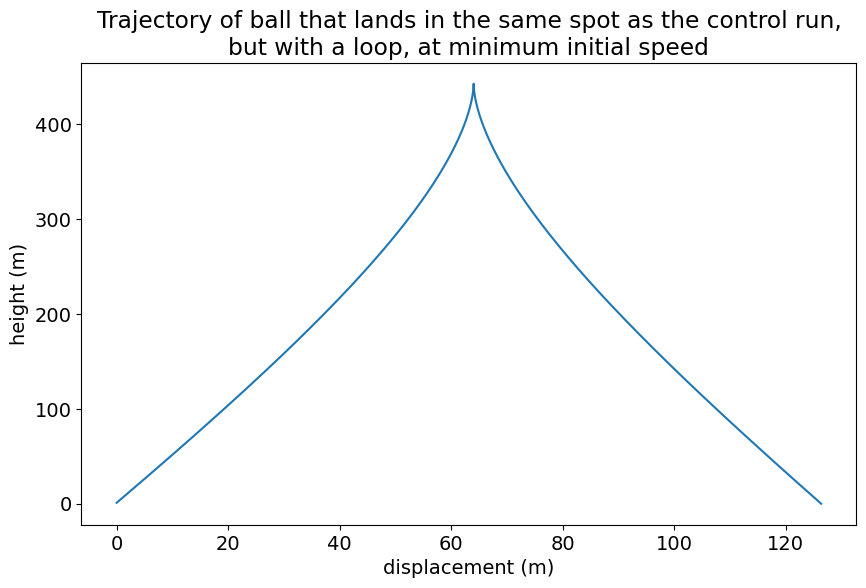

In [9]:
val = p3_task3()
